# Planet API + STAC

Goal: Just Search (no downloads) Planet API v2 and assess estimated cloud cover

https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/v2_earlyaccess/

mamba create -n planet geopandas ipykernel geocube pyarrow pystac-client

https://planet-sdk-for-python-v2.readthedocs.io/en/latest/get-started/upgrading/

https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-guide/#session


In [1]:
import planet
import getpass
import geopandas as gpd
import asyncio
from datetime import datetime

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%config InlineBackend.figure_format='retina'

In [3]:
planet.__version__

'2.0.0-rc.3dev'

In [4]:
#os.environ['PL_API_KEY'] = 'xxxxxx'
api_key = getpass.getpass()
auth = planet.Auth.from_key(api_key)
auth.store()

 ········


In [5]:
# NOTE: how to test authentication?
async def main():
    sess = planet.Session(auth=auth)
    # perform operations here
    await sess.aclose()

# asyncio.run(main()) # RuntimeError: asyncio.run() cannot be called from a running event loop (jupyter notebook)
await main()

## Search settings

In [6]:
ngozumpa = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              86.65835356786732,
              28.08444981415515
            ],
            [
              86.65835356786732,
              27.92446188439763
            ],
            [
              86.7381701103065,
              27.92446188439763
            ],
            [
              86.7381701103065,
              28.08444981415515
            ],
            [
              86.65835356786732,
              28.08444981415515
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [7]:
# https://developers.planet.com/docs/planetschool/searching-for-imagery-with-data-api/#itemtypes
item_type_id = 'PSScene'

geom_filter = planet.data_filter.geometry_filter(ngozumpa)

date_filter = planet.data_filter.date_range_filter('acquired', 
                                        gte=datetime.fromisoformat("2022-11-18"), 
                                        lte=datetime.fromisoformat("2022-11-21"))

cloud_filter = planet.data_filter.range_filter('cloud_cover', lte=0.1)

#download_filter = planet.data_filter.permission_filter()

# Combine filters for search
all_filters = planet.data_filter.and_filter([geom_filter, 
                                             date_filter,
                                             #cloud_filter,
                                            ])

## Small search 

In [8]:
# NOTE: only retuns 100 by default
# https://planet-sdk-for-python-v2.readthedocs.io/en/latest/python/sdk-reference/#planet.clients.data.DataClient.search

async with planet.Session(auth=auth) as session:
    items = [i async for i in session.client('data').search([item_type_id], all_filters, limit=None)]
    
print(f'Found {len(items)} items')

Found 5 items


In [9]:
# NOTE: unfortunately this is not STAC metadata, but it is a GeoJSON feature, so we can use geopandas
# STAC is only for Orders
# https://planet-sdk-for-python-v2.readthedocs.io/en/latest/cli/cli-orders/?h=stac#stac-metadata

gf = gpd.GeoDataFrame.from_features(items)
gf.head(3)

,geometry,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,...,satellite_id,shadow_percent,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent
0,"POLYGON ((86.54648 28.03744, 86.50380 27.85534...",2022-11-19T04:28:38.745009Z,0,86,76,0,0,True,3.9,0,...,2484,4,20,6088214,152.9,37.9,2022-11-20T04:35:02Z,0.4,75,100
1,"POLYGON ((86.58000 28.18543, 86.53752 28.00319...",2022-11-19T04:28:36.398339Z,0,80,46,0,0,True,3.9,0,...,2484,3,51,6088214,152.9,37.8,2022-11-20T04:35:00Z,0.4,68,100
2,"POLYGON ((86.47618 28.00939, 86.43500 27.82530...",2022-11-18T04:26:43.123327Z,0,87,65,0,0,True,3.9,0,...,248e,6,30,6085985,152.6,38.2,2022-11-19T04:36:35Z,4.8,75,100


## Big search 


In [10]:
# Just filter by geometry, all time
all_filters = planet.data_filter.and_filter([geom_filter, 
                                            ])

In [11]:
start = datetime.now()

async with planet.Session(auth=auth) as session:
    items = [i async for i in session.client('data').search([item_type_id], all_filters, limit=None)]
    
finish = datetime.now()
elapsed_time = finish - start
print(f'Found {len(items)} items in {elapsed_time} s')

Found 9348 items in 0:00:40.790300 s


In [12]:
gf = gpd.GeoDataFrame.from_features(items)
gf.head(3)

,geometry,acquired,anomalous_pixels,clear_confidence_percent,clear_percent,cloud_cover,cloud_percent,ground_control,gsd,heavy_haze_percent,...,satellite_id,shadow_percent,snow_ice_percent,strip_id,sun_azimuth,sun_elevation,updated,view_angle,visible_confidence_percent,visible_percent
0,"POLYGON ((86.61383 28.07829, 86.57281 27.90343...",2023-04-03T03:48:52.9116Z,0.0,71.0,29.0,0.01,1.0,True,3.7,0.0,...,2451,0.0,70.0,6404995,116.5,48.6,2023-04-03T22:35:04Z,5.0,67.0,99.0
1,"POLYGON ((86.64441 28.21893, 86.60485 28.04375...",2023-04-03T03:48:50.694396Z,0.0,71.0,40.0,0.03,3.0,True,3.7,0.0,...,2451,0.0,57.0,6404995,116.7,48.6,2023-04-03T22:35:04Z,5.0,62.0,97.0
2,"POLYGON ((86.69830 28.01821, 86.66140 27.85572...",2023-04-01T04:15:24.469187Z,0.0,49.0,8.0,0.29,29.0,True,3.5,0.0,...,2262,0.0,63.0,6399443,124.0,53.1,2023-04-02T04:03:12Z,4.9,54.0,71.0


In [13]:
gf.iloc[0]

geometry                      POLYGON ((86.61382906682319 28.078287412449473...
acquired                                              2023-04-03T03:48:52.9116Z
anomalous_pixels                                                            0.0
clear_confidence_percent                                                   71.0
clear_percent                                                              29.0
cloud_cover                                                                0.01
cloud_percent                                                               1.0
ground_control                                                             True
gsd                                                                         3.7
heavy_haze_percent                                                          0.0
instrument                                                               PSB.SD
item_type                                                               PSScene
light_haze_percent                      

In [14]:
# Any dublicates... no?
gf.acquired.duplicated().sum()

0

In [15]:
gf.quality_category.value_counts()

quality_category
test        5296
standard    4052
Name: count, dtype: int64

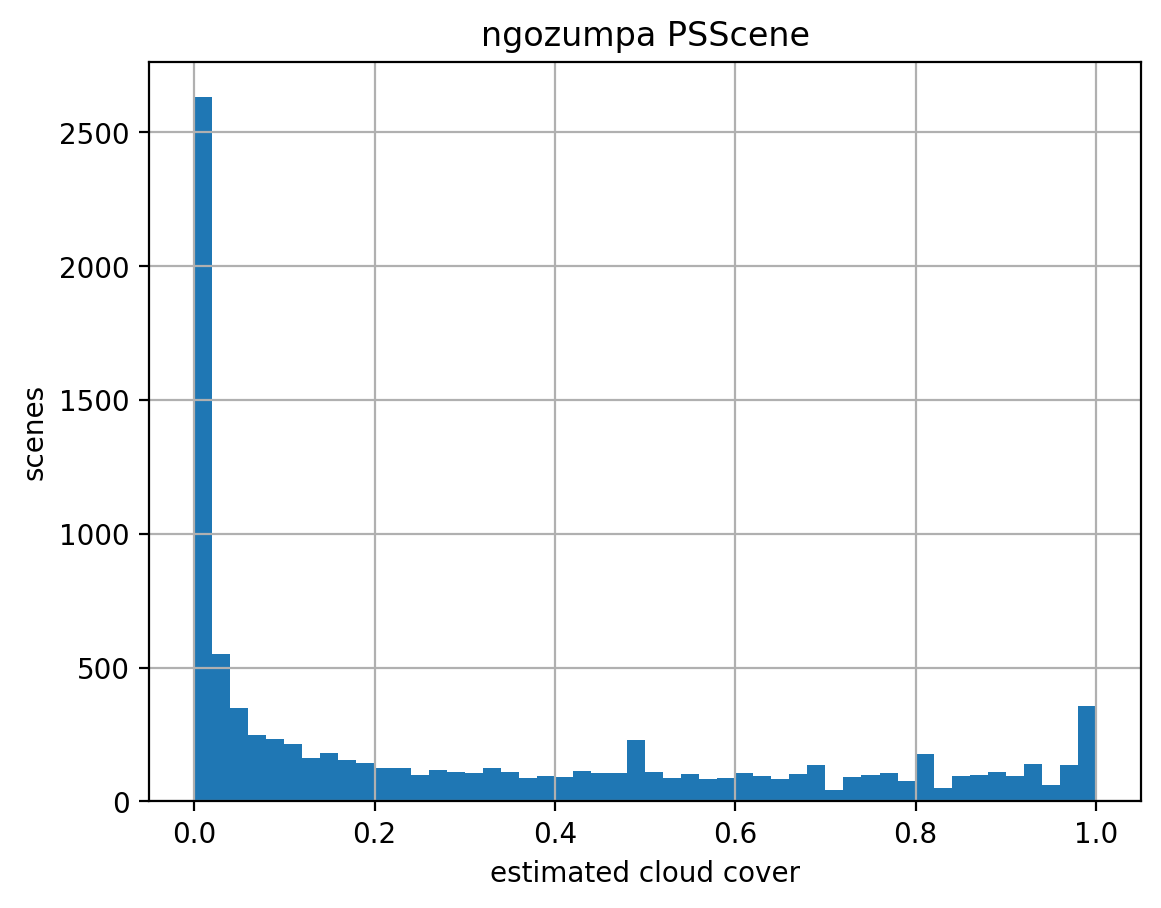

In [16]:
fig,ax=plt.subplots()
gf.cloud_cover.hist(bins=50, ax=ax)
plt.xlabel('estimated cloud cover')
plt.ylabel('scenes')
plt.title(f'ngozumpa {item_type_id}');

In [17]:
# plot scenes over time colored by cloud cover
gf['time'] = gpd.pd.to_datetime(gf.acquired)

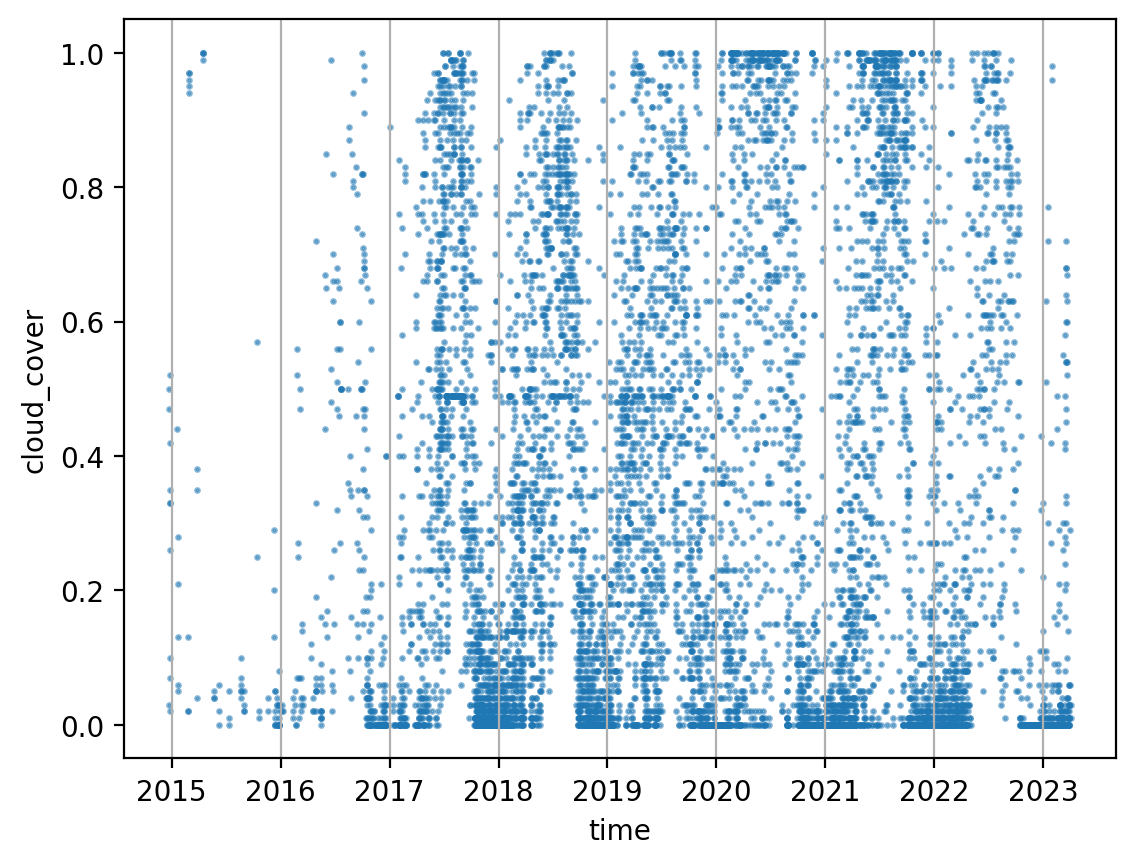

In [18]:
gf.plot.scatter(x='time', y='cloud_cover', s=2, alpha=0.5);
plt.grid(axis='x')

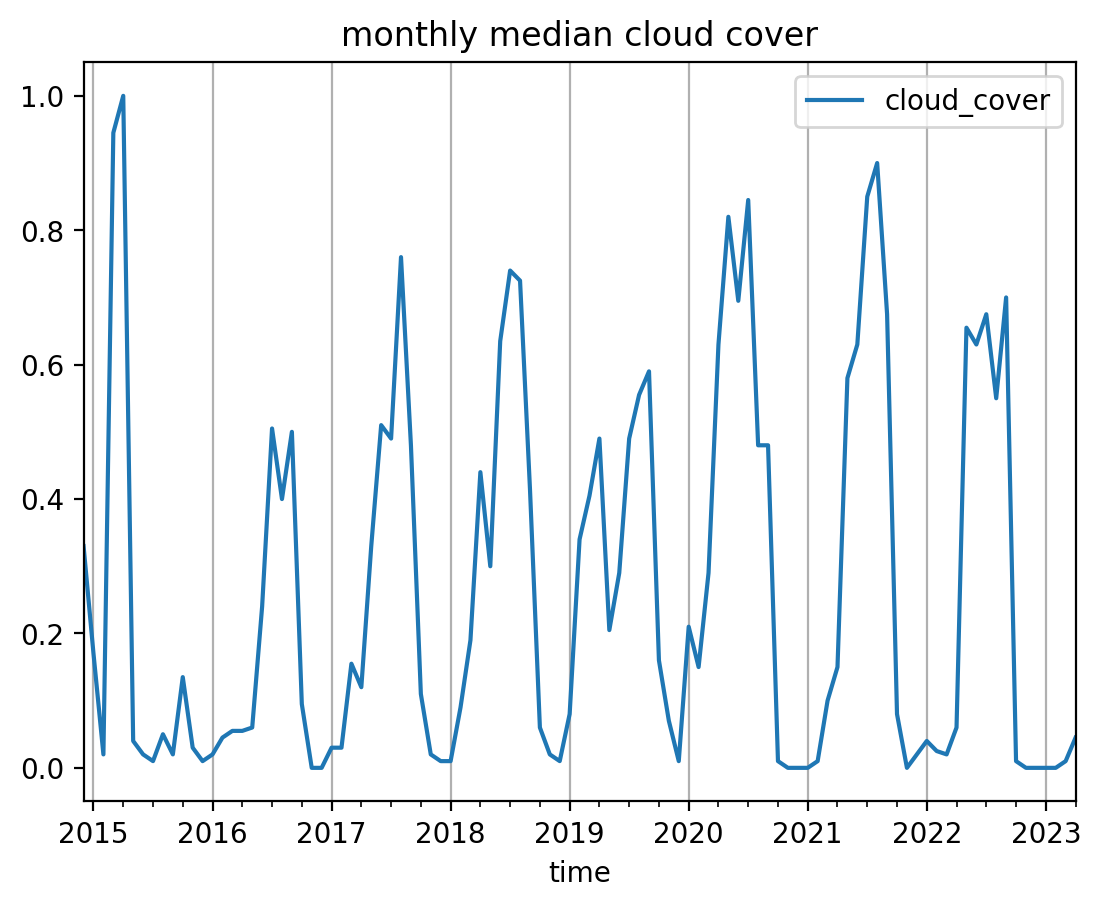

In [19]:
# Simplify with a monthly mean
tmp = gf.loc[:,['time','cloud_cover']].set_index('time')
#tmp.resample('1M').agg(['median', 'std'])
tmp.resample('1M').median().plot(title='monthly median cloud cover');
plt.grid(axis='x')

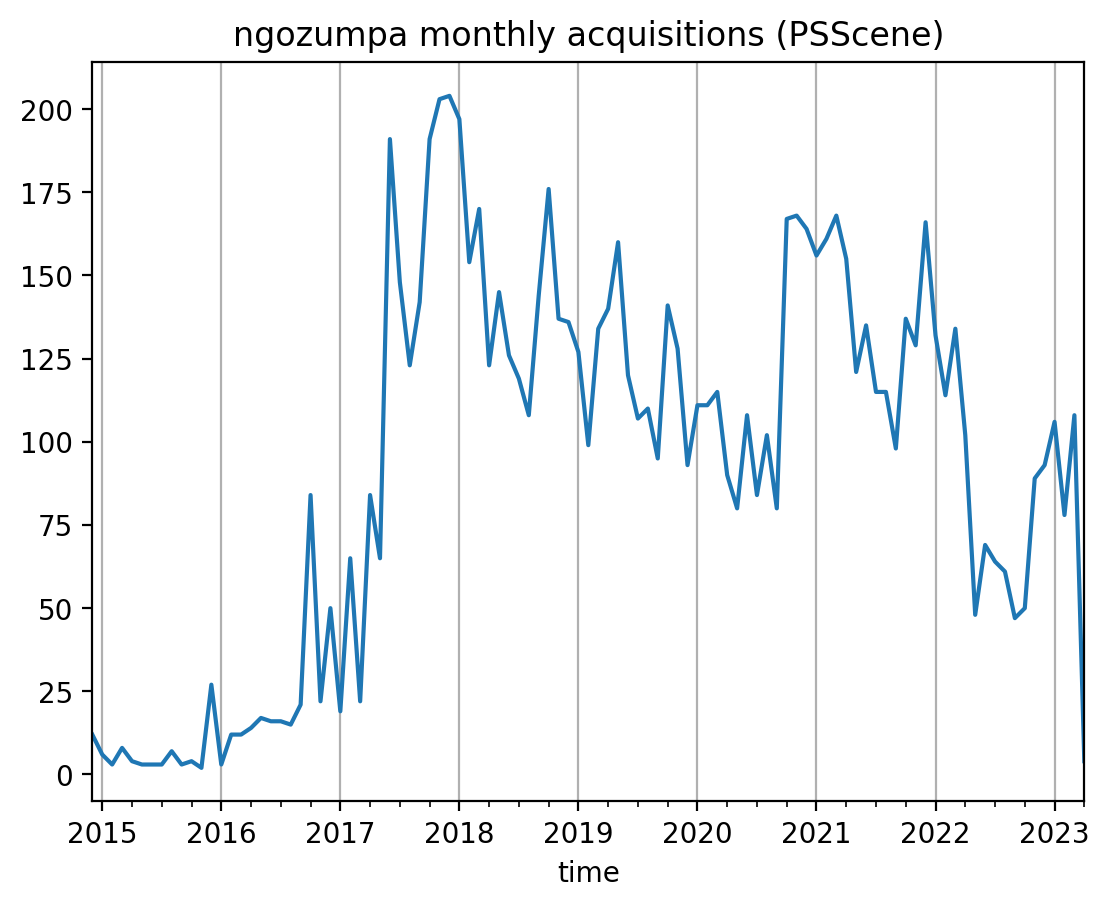

In [20]:
tmp = gf.loc[:,['time','cloud_cover']].set_index('time')
tmp = tmp.resample('1M').agg(['mean', 'std', 'count']) # creates multi-index
tmp.plot(y=('cloud_cover', 'count'), legend=False);
plt.title(f'ngozumpa monthly acquisitions ({item_type_id})');
plt.grid(axis='x')

In [21]:
# We also have foot-prints so consolidate spatial coverage in a figure:
# Heat map of coverage
from geocube.api.core import make_geocube
from geocube.rasterize import rasterize_image
from functools import partial
from rasterio.enums import MergeAlg

In [22]:
# Heat Map
gf['counts'] = 1

full_grid = make_geocube(
    vector_data=gf,
    #group_by = 'sat:relative_orbit',
    measurements=['counts'],
    resolution=(0.001, 0.001),
    rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add), 
    fill=0,
)

full_grid

<xarray.Dataset>
Dimensions:      (y: 672, x: 894)
Coordinates:
  * y            (y) float64 27.67 27.67 27.67 27.67 ... 28.34 28.34 28.34 28.34
  * x            (x) float64 86.25 86.25 86.25 86.25 ... 87.14 87.14 87.14 87.14
    spatial_ref  int64 0
Data variables:
    counts       (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

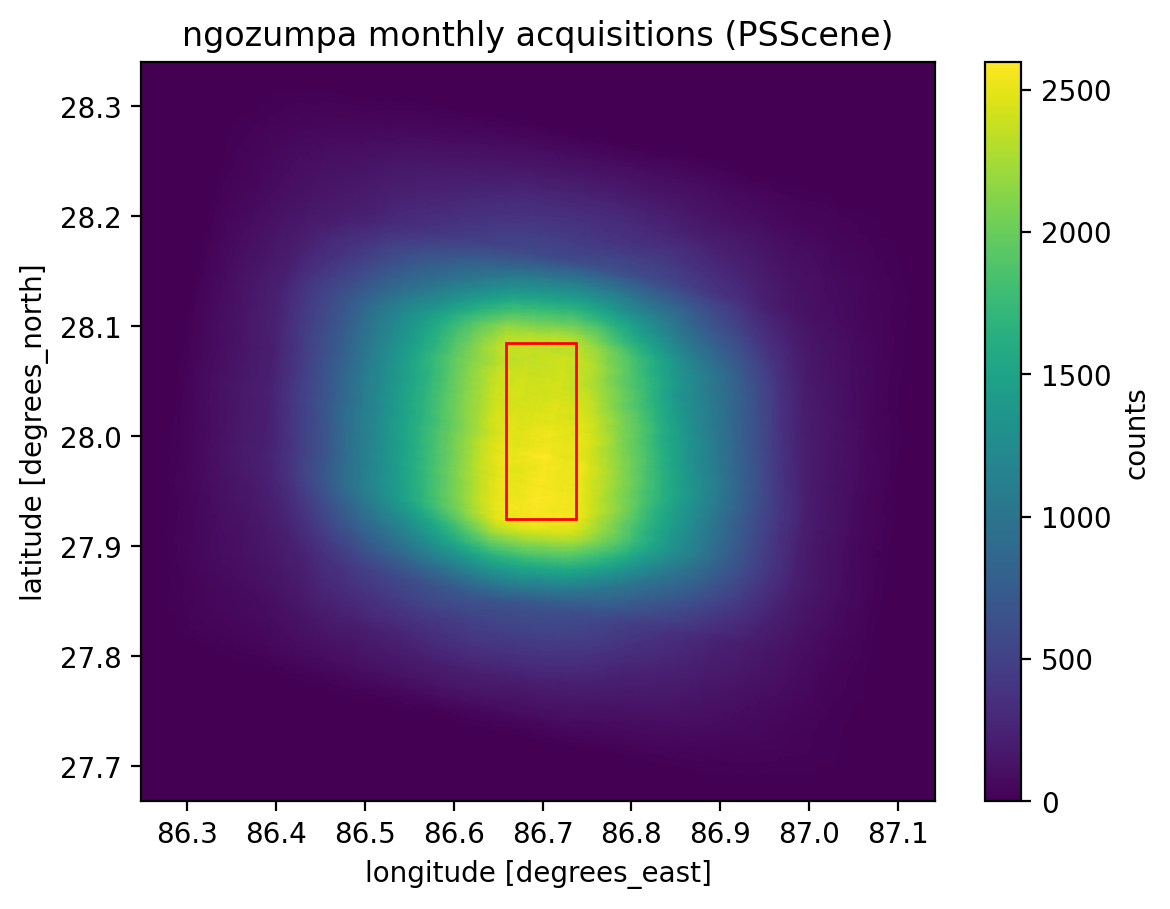

In [23]:
fig,ax = plt.subplots()

full_grid.counts.plot(ax=ax)

# Add AOI 
search_coords = ngozumpa['features'][0]['geometry']['coordinates'][0]
rect = patches.Polygon(search_coords, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title(f'ngozumpa monthly acquisitions ({item_type_id})');

In [24]:
# Look at evolution of coverage over time
# Heat Map
gf['year'] = gf.time.dt.year

full_grid = make_geocube(
    vector_data=gf,
    group_by = 'year',
    measurements=['counts'],
    resolution=(0.001, 0.001),
    rasterize_function=partial(rasterize_image, merge_alg=MergeAlg.add), 
    fill=0,
)

full_grid

<xarray.Dataset>
Dimensions:      (year: 10, y: 672, x: 894)
Coordinates:
  * y            (y) float64 27.67 27.67 27.67 27.67 ... 28.34 28.34 28.34 28.34
  * x            (x) float64 86.25 86.25 86.25 86.25 ... 87.14 87.14 87.14 87.14
  * year         (year) int64 2014 2015 2016 2017 2018 2019 2020 2021 2022 2023
    spatial_ref  int64 0
Data variables:
    counts       (year, y, x) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

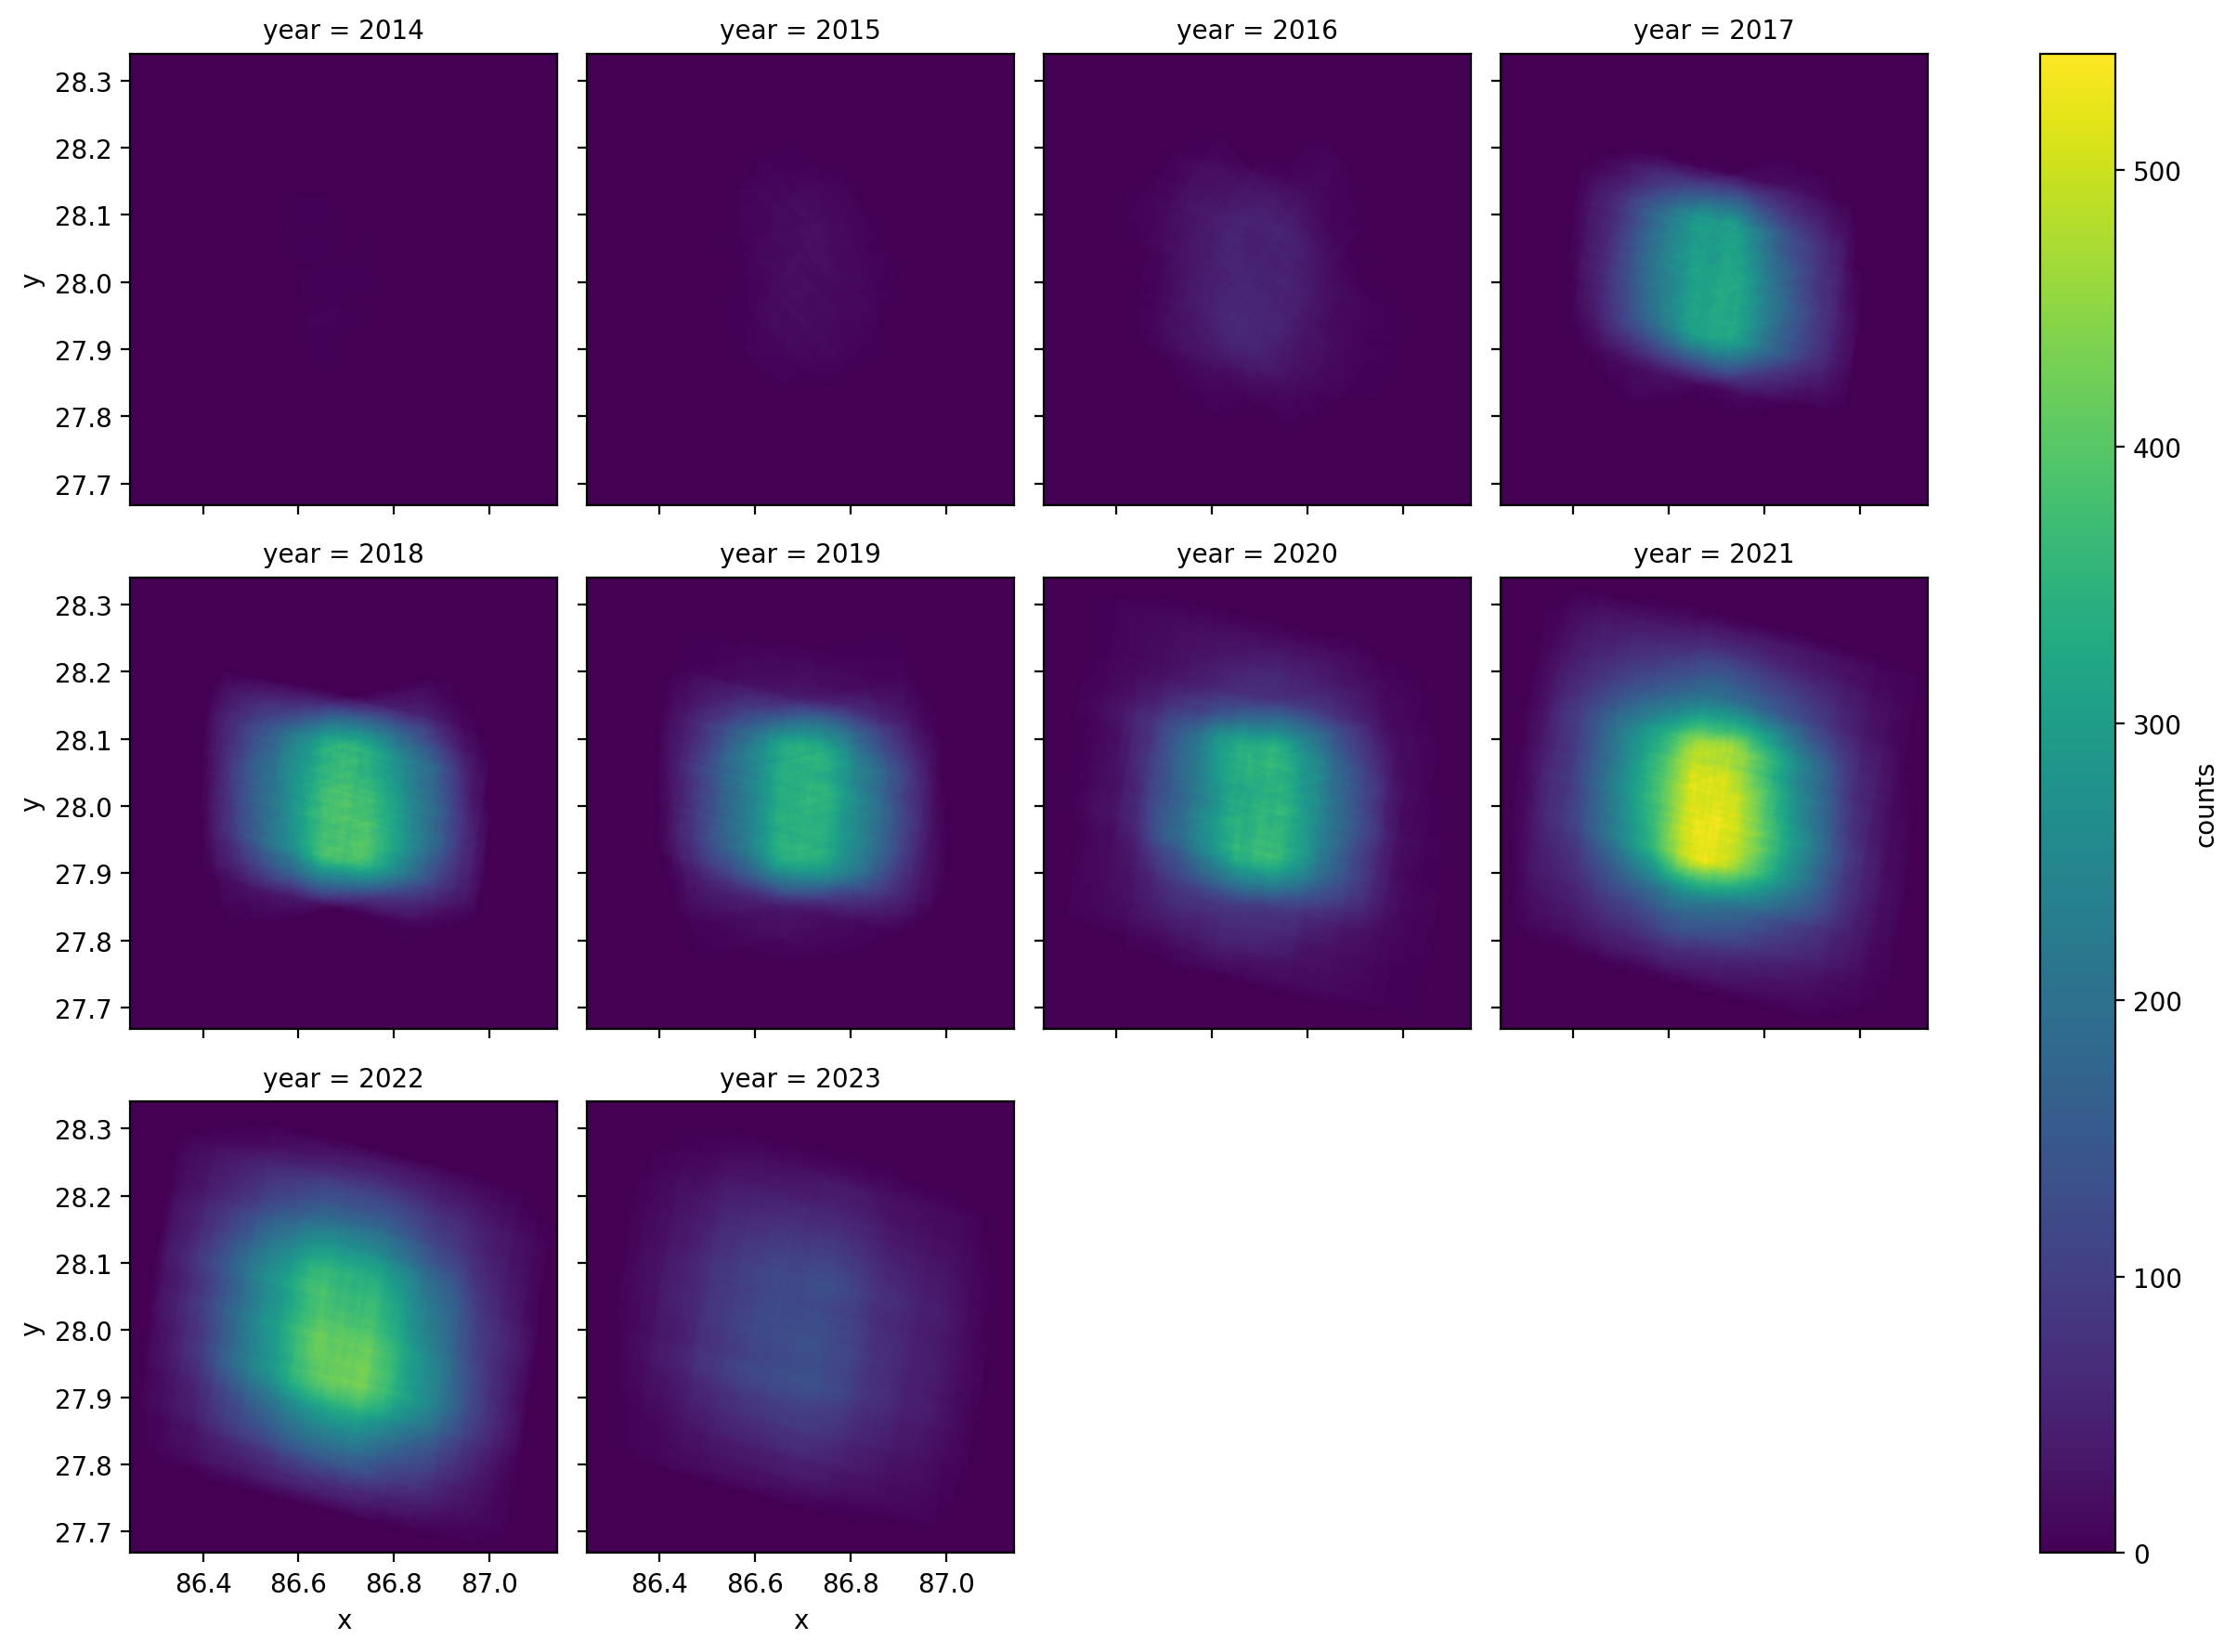

In [25]:
full_grid.counts.plot(col='year', col_wrap=4);

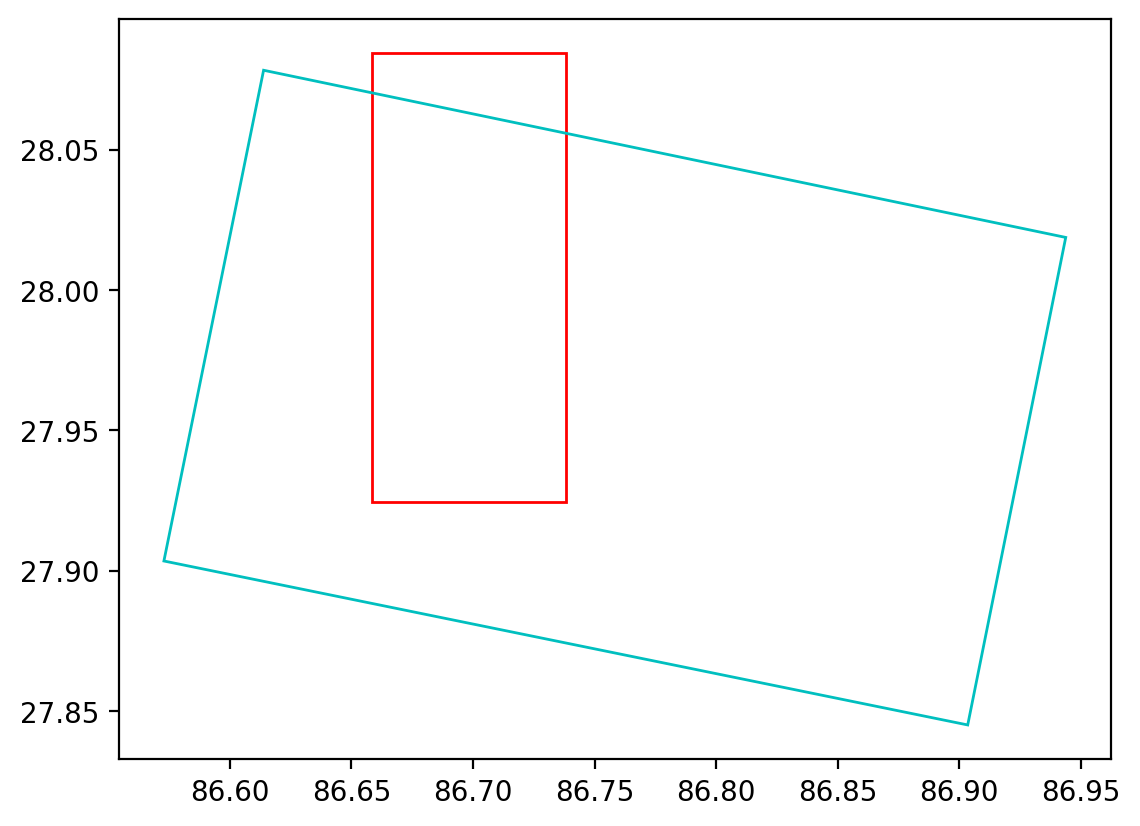

In [27]:
# Plot footprint of single scene relative to AOI
fig,ax = plt.subplots()
search_coords = ngozumpa['features'][0]['geometry']['coordinates'][0]
rect = patches.Polygon(search_coords, linewidth=1, edgecolor='r', facecolor='none', label='aoi')
ax.add_patch(rect)

i = 0
footprint = list(gf.geometry.iloc[i].boundary.coords)
rect = patches.Polygon(footprint, linewidth=1, edgecolor='c', facecolor='none', label=gf.iloc[i])
ax.add_patch(rect)

plt.autoscale()

In [28]:
# interactive w/ basemap
#gf.iloc[:3].drop(columns='time').explore()

# Save for later

In [29]:
gf.to_parquet('planet.parquet',  version='2.6')

## Same AOI, Landsat-8 & Sentinel-2

In [30]:
import pystac_client

In [31]:
%%time
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    #modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["landsat-c2-l2"],
    #bbox=bbox_of_interest,
    intersects=ngozumpa['features'][0]['geometry'],
    datetime=['2014',None],
    #query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 646 Items
CPU times: user 1.18 s, sys: 61.5 ms, total: 1.24 s
Wall time: 7.99 s


In [32]:
# Items is a list of GeoJON Features, you can turn it into a GeoPandas table for convenient exploration:
gfL = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')

gfL.head(3)

,geometry,gsd,created,sci:doi,datetime,platform,proj:epsg,proj:shape,description,instruments,...,landsat:wrs_row,landsat:scene_id,landsat:wrs_path,landsat:wrs_type,view:sun_azimuth,landsat:correction,view:sun_elevation,landsat:cloud_cover_land,landsat:collection_number,landsat:collection_category
0,"POLYGON ((86.09285 28.47073, 85.66624 26.74417...",30,2023-03-26T05:28:12.621825Z,10.5066/P9OGBGM6,2023-03-20T04:42:17.457903Z,landsat-9,32645,"[7791, 7641]",Landsat Collection 2 Level-2,"[oli, tirs]",...,041,LC91400412023079LGN00,140,2,135.555128,L2SP,53.628486,77.83,02,T1
1,"POLYGON ((86.45021 29.90906, 86.02225 28.18213...",30,2023-03-26T05:28:11.761717Z,10.5066/P9OGBGM6,2023-03-20T04:41:53.562652Z,landsat-9,32645,"[7771, 7641]",Landsat Collection 2 Level-2,"[oli, tirs]",...,040,LC91400402023079LGN00,140,2,137.232349,L2SP,52.748532,18.16,02,T1
2,"POLYGON ((86.09895 28.47348, 85.67224 26.74639...",30,2023-03-25T05:31:23.157997Z,10.5066/P9OGBGM6,2023-03-12T04:42:08.802143Z,landsat-8,32645,"[7791, 7651]",Landsat Collection 2 Level-2,"[oli, tirs]",...,041,LC81400412023071LGN02,140,2,137.933568,L2SP,50.763461,10.45,02,T1


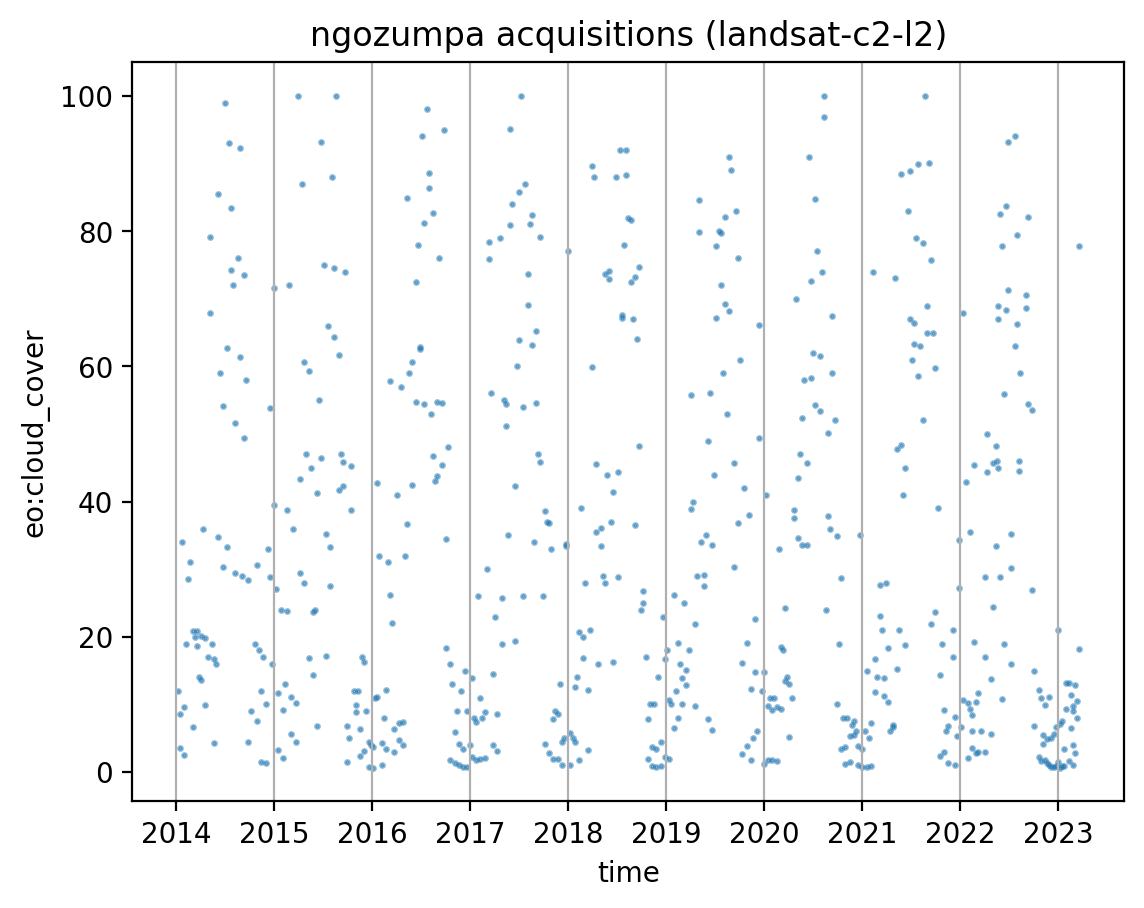

In [33]:
gfL['time'] = gpd.pd.to_datetime(gfL.datetime)
gfL.plot.scatter(x='time', y='eo:cloud_cover', s=2, alpha=0.5);
plt.grid(axis='x')
plt.title(f'ngozumpa acquisitions (landsat-c2-l2)');

In [34]:
tmp = gfL.loc[:,['time','eo:cloud_cover']].set_index('time')
tmp = tmp.resample('1M').agg(['mean', 'std', 'count']) # creates multi-index

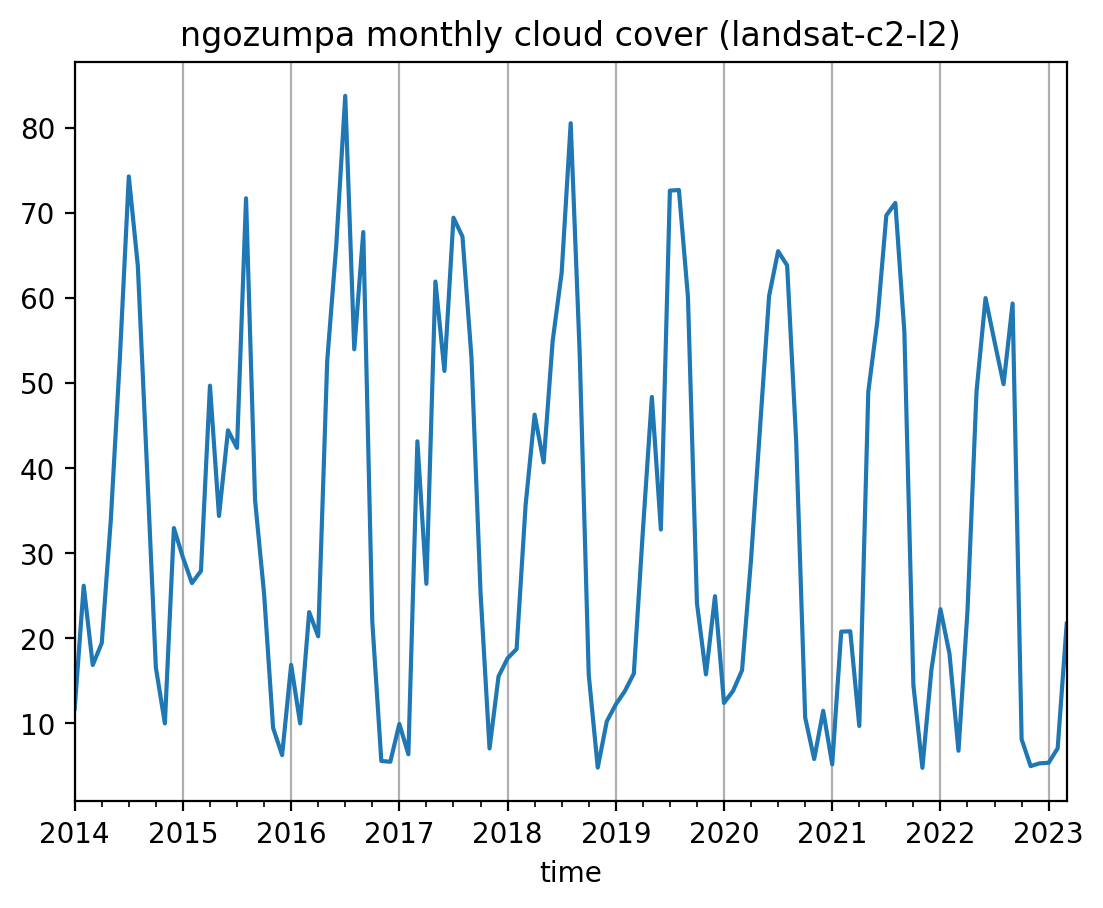

In [35]:
tmp.plot(y=('eo:cloud_cover', 'mean'), legend=False);
plt.title(f'ngozumpa monthly cloud cover (landsat-c2-l2)');
plt.grid(axis='x')

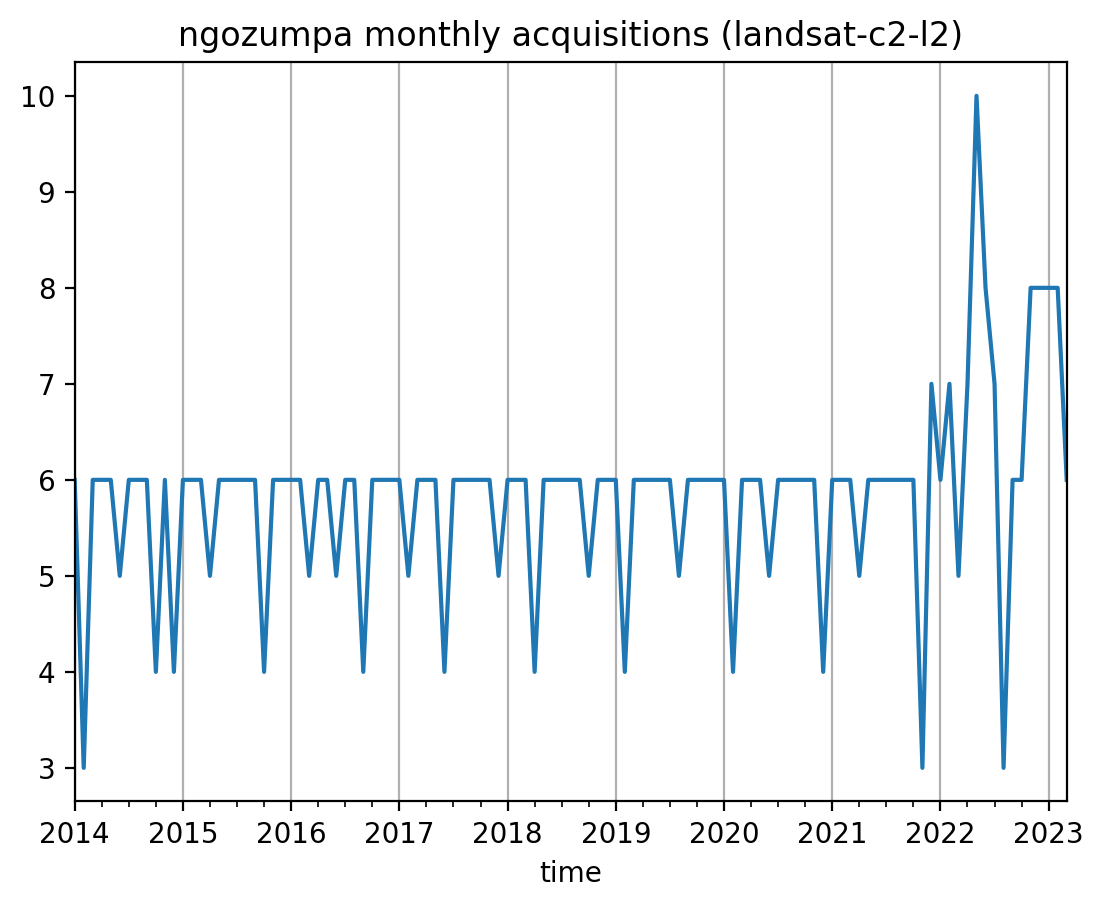

In [36]:
tmp.plot(y=('eo:cloud_cover', 'count'), legend=False);
plt.title(f'ngozumpa monthly acquisitions (landsat-c2-l2)');
plt.grid(axis='x')

In [37]:
gfL.to_parquet('landsat.parquet')

In [38]:
%%time
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    #modifier=planetary_computer.sign_inplace,
)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    #bbox=bbox_of_interest,
    intersects=ngozumpa['features'][0]['geometry'],
    datetime=['2014',None],
    #query={"eo:cloud_cover": {"lt": 10}},
)

items = search.get_all_items()
print(f"Returned {len(items)} Items")

Returned 835 Items
CPU times: user 986 ms, sys: 24 ms, total: 1.01 s
Wall time: 9.29 s


In [39]:
# Items is a list of GeoJON Features, you can turn it into a GeoPandas table for convenient exploration:
gfS = gpd.GeoDataFrame.from_features(items.to_dict(), crs='EPSG:4326')

gfS.head(3)

,geometry,datetime,platform,proj:epsg,instruments,s2:mgrs_tile,constellation,s2:granule_id,eo:cloud_cover,s2:datatake_id,...,s2:cloud_shadow_percentage,s2:nodata_pixel_percentage,s2:unclassified_percentage,s2:dark_features_percentage,s2:not_vegetated_percentage,s2:degraded_msi_data_percentage,s2:high_proba_clouds_percentage,s2:reflectance_conversion_factor,s2:medium_proba_clouds_percentage,s2:saturated_defective_pixel_percentage
0,"POLYGON ((85.97367 28.92437, 87.10014 28.92825...",2023-04-02T04:47:09.024000Z,Sentinel-2B,32645,[msi],45RVM,Sentinel 2,S2B_OPER_MSI_L2A_TL_MSFT_20230402T100935_A0317...,2.686056,GS2B_20230402T044709_031705_N05.09,...,0.393436,0.000000,0.079180,0.370005,62.183136,0.2587,1.598104,1.003820,1.087953,0.0
1,"POLYGON ((85.98236 28.02167, 87.09929 28.02540...",2023-04-02T04:47:09.024000Z,Sentinel-2B,32645,[msi],45RVL,Sentinel 2,S2B_OPER_MSI_L2A_TL_MSFT_20230402T102223_A0317...,43.049014,GS2B_20230402T044709_031705_N05.09,...,5.251035,0.000007,0.588396,0.845949,12.493878,0.3470,32.798824,1.003820,10.192097,0.0
2,"POLYGON ((85.97367 28.92437, 87.10014 28.92825...",2023-03-28T04:47:01.024000Z,Sentinel-2A,32645,[msi],45RVM,Sentinel 2,S2A_OPER_MSI_L2A_TL_MSFT_20230328T092851_A0405...,10.720986,GS2A_20230328T044701_040542_N05.09,...,0.429372,0.000000,1.128712,1.333048,60.222018,0.0880,7.035445,1.006684,3.685542,0.0


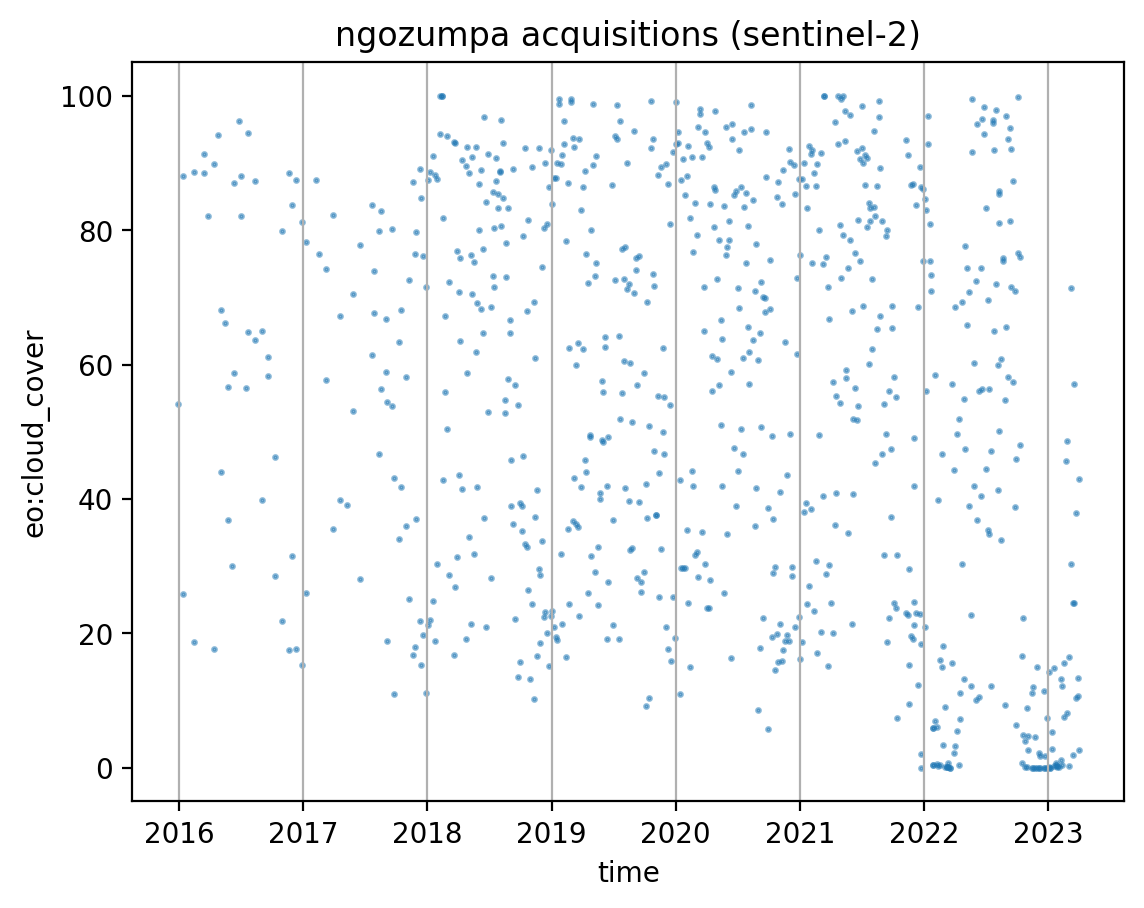

In [40]:
gfS['time'] = gpd.pd.to_datetime(gfS.datetime)
gfS.plot.scatter(x='time', y='eo:cloud_cover', s=2, alpha=0.5);
plt.grid(axis='x')
plt.title(f'ngozumpa acquisitions (sentinel-2)');

In [41]:
tmp = gfS.loc[:,['time','eo:cloud_cover']].set_index('time')
tmp = tmp.resample('1M').agg(['mean', 'std', 'count']) # creates multi-index

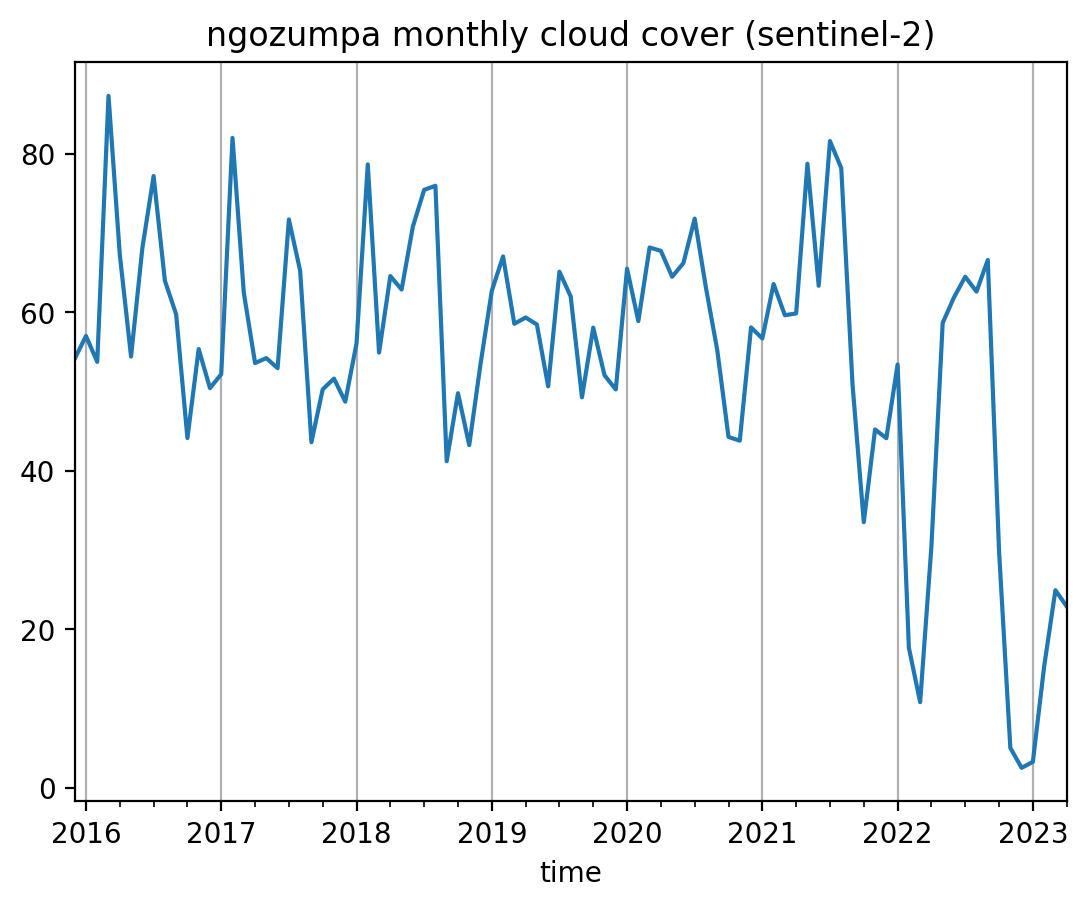

In [42]:
tmp.plot(y=('eo:cloud_cover', 'mean'), legend=False);
plt.title(f'ngozumpa monthly cloud cover (sentinel-2)');
plt.grid(axis='x')

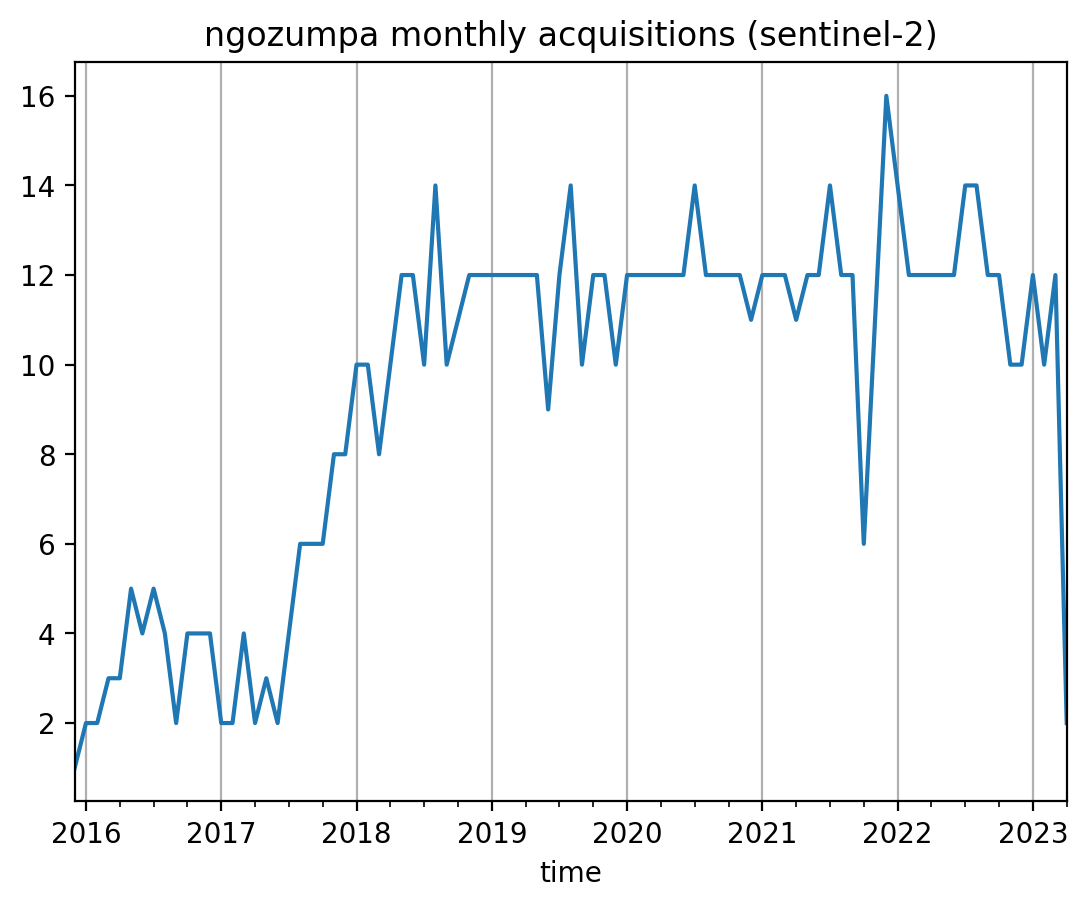

In [43]:
tmp.plot(y=('eo:cloud_cover', 'count'), legend=False);
plt.title(f'ngozumpa monthly acquisitions (sentinel-2)');
plt.grid(axis='x')

In [44]:
gfS.to_parquet('sentinel.parquet')